## L1 - Detailed Metrics and Cross-validation

### Classification example

In [1]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, confusion_matrix

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import SGDClassifier

In [3]:
X, y = load_breast_cancer(return_X_y=True)
skfold = StratifiedKFold()

metrics = {"classification_report": [], "roc_auc_score": [], "log_loss": [], "confusion_matrix": []}

for train_split, test_split in skfold.split(X, y):
    sgd = SGDClassifier(loss="log")
    sgd.fit(X[train_split], y[train_split])
    pred_proba = sgd.predict_proba(X[test_split])
    pred = sgd.predict(X[test_split])
    metrics["classification_report"].append(classification_report(y[test_split], pred))
    metrics["confusion_matrix"].append(confusion_matrix(y[test_split], pred))
    metrics["roc_auc_score"].append(roc_auc_score(y[test_split], pred))
    metrics["log_loss"].append(log_loss(y[test_split], pred_proba))
    
    print("Accuracy on the split is", sgd.score(X[test_split], y[test_split]))

Accuracy on the split is 0.8421052631578947
Accuracy on the split is 0.9122807017543859
Accuracy on the split is 0.9035087719298246
Accuracy on the split is 0.956140350877193
Accuracy on the split is 0.9203539823008849


In [4]:
for k, vs in metrics.items():
    print(k)
    [print(f"On split {idx}:\n", v) for idx, v in enumerate(vs)]
    print("\n\n")

classification_report
On split 0:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82        43
           1       0.96      0.77      0.86        71

    accuracy                           0.84       114
   macro avg       0.84      0.86      0.84       114
weighted avg       0.87      0.84      0.84       114

On split 1:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87        43
           1       0.89      0.99      0.93        71

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114

On split 2:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        42
           1       0.97      0.88      0.92        72

    accuracy                           0.90       114
   macro avg       0.89      0.91      0.90       114
weighted avg 

In [18]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

import matplotlib.pyplot as plt

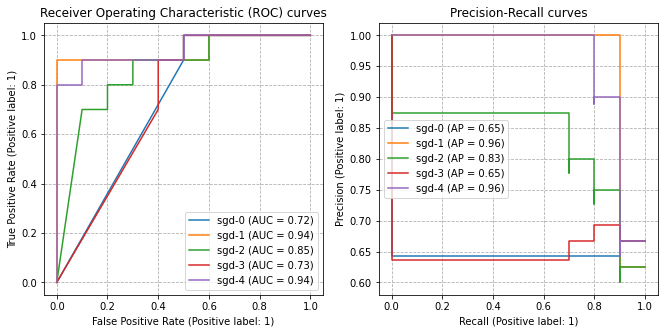

In [19]:
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(11, 5))

for split_no, (train_split, test_split) in enumerate(skfold.split(X, y)):
    sgd = SGDClassifier(loss="log")
    sgd.fit(X[train_split], y[train_split])

    plot_roc_curve(sgd, X[test_split], y[test_split], ax=ax_roc, name=f"sgd-{split_no}")
    plot_precision_recall_curve(sgd, X[test_split], y[test_split], ax=ax_pr, name=f"sgd-{split_no}")


ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_pr.set_title('Precision-Recall curves')

ax_roc.grid(linestyle='--')
ax_pr.grid(linestyle='--')

plt.legend()
plt.show()

Maybe plot Precision-Recall curves one by one.

### Regression example

In [1]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [2]:
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml

from sklearn.linear_model import SGDRegressor

In [3]:
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html

def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]

In [4]:
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html

df = load_mtpl2(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

In [5]:
from functools import partial

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer


log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

In [9]:
# https://medium.com/analytics-vidhya/probabilistic-model-selection-with-aic-bic-in-python-f8471d6add32

def adj_r2(y, y_hat, X):
    r2 = r2_score(y, y_hat)
    n, p = X.shape[0], X.shape[1]
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def aic(y, y_hat, X):
    return 2 * X.shape[1] - 2 * np.log(mean_squared_error(y, y_hat))


def aic_c(y, y_hat, X):
    k, n = X.shape[1], X.shape[0]
    return aic(y, y_hat, X) + (2 * k * k + 2 * k) / (n - k - 1)


def bic(y, y_hat, X):
    return np.log(X.shape[0]) * X.shape[1] - 2 * np.log(mean_squared_error(y, y_hat))

In [11]:
X = column_trans.fit_transform(df)
y = df.ClaimAmount.values

skfold = KFold()
metrics = {"rmse": [], "mape": [], "r2": []}

for train_split, test_split in skfold.split(X, y):
    sgd = SGDRegressor(max_iter=10_000)
    sgd.fit(X[train_split], y[train_split])
    pred = sgd.predict(X[test_split])
    
    pred_ = sgd.predict(X[train_split])
    print(adj_r2(y[train_split], pred_, X[train_split]))
    print(aic(y[train_split], pred_, X[train_split]))
    print(aic_c(y[train_split], pred_, X[train_split]))
    print(bic(y[train_split], pred_, X[train_split]))
    print()
    
    metrics["rmse"].append(mean_squared_error(y[test_split], pred, squared=False))
    metrics["mape"].append(mean_absolute_percentage_error(y[test_split], pred))
    metrics["r2"].append(r2_score(y[test_split], pred))

/home/alexburlacu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


-50906618.52462311
82.29604534763813
82.52765724122185
731.9388107995002
-0.21314855345613326
117.41955972837718
117.6511716219609
767.0623251802392
-1.3606507861849448
116.28036998576881
116.51198187935253
765.9231354376309
-0.7125382450473341
116.65318625748374
116.88479815106746
766.2959517093458
-0.7535923580939468
117.34211021580272
117.57372210938644
766.9848756676647


In [8]:
for k, vs in metrics.items():
    print(k)
    [print(f"On split {idx}:\n", v) for idx, v in enumerate(vs)]
    print("\n\n")

rmse
On split 0:
 228941762.74514997
On split 1:
 2115.73679210225
On split 2:
 23488769.559470326
On split 3:
 3105.6141868112186
On split 4:
 2836.77302753825



mape
On split 0:
 6.259678763148708e+23
On split 1:
 1.5465199224592215e+18
On split 2:
 1.0383001475741364e+22
On split 3:
 4.823221355436087e+18
On split 4:
 4.347182015115834e+18



r2
On split 0:
 -22778107965.65319
On split 1:
 -0.8350244416125194
On split 2:
 -146666750.1063814
On split 3:
 -4.1469843897754215
On split 4:
 -0.23947949131420354





See also:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
- https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b
- https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html
- https://stackoverflow.com/questions/54945196/sklearn-stratified-k-fold-cv-with-linear-model-like-elasticnetcv
